# Exploratory Analysis

---

This notebook outlines the exploratory analysis process for identifying drivers of churn in the Telco customer dataset.

---

## Acquire and Prepare Data

First let's acquire and prepare our data using the functions we previously created.

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from env import username, password, hostname
database_name = 'telco_churn'

def get_db_url(database_name, username = username, password = password, hostname = hostname):
    return f'mysql+pymysql://{username}:{password}@{hostname}/{database_name}'

def get_telco_sql():
    return '''
        SELECT *
        FROM customers
        JOIN payment_types USING (payment_type_id)
        JOIN internet_service_types USING (internet_service_type_id)
        JOIN contract_types USING (contract_type_id);
    '''

def get_telco_data(use_cache = True):
    # If the file is cached, read from the .csv file
    if os.path.exists('telco.csv') and use_cache:
        print('Using cache')
        return pd.read_csv('telco.csv')
    
    # Otherwise read from the mysql database
    else:
        print('Reading from database')
        df = pd.read_sql(get_telco_sql(), get_db_url('telco_churn'))
        df.to_csv('telco.csv', index = False)
        return df
    
def prep_telco_data(df):
    df = df.drop_duplicates()

    cols_to_drop = [
        'customer_id',
        'contract_type_id',
        'internet_service_type_id',
        'payment_type_id'
    ]
    df = df.drop(columns = cols_to_drop)

    does_not_have_zero_tenure = df.tenure != 0
    df = df[does_not_have_zero_tenure]
    df.total_charges = df.total_charges.astype('float')

    columns = [
        'multiple_lines',
        'online_security',
        'online_backup',
        'device_protection',
        'tech_support',
        'streaming_tv',
        'streaming_movies'
    ]

    for column in columns:
        df[column] = np.where(df[column] == 'Yes', 'Yes', 'No')

    categorical_cols = df.dtypes[df.dtypes == 'object'].index

    dummy_df = pd.get_dummies(df[categorical_cols], dummy_na = False, drop_first = True)
    df = pd.concat([df, dummy_df], axis = 1)

    df.columns = df.columns.str.replace(' ', '_', regex = False).str.lower()
    df.columns = df.columns.str.replace('\(|\)', '', regex = True)

    return df

def split_data(df, stratify, random_seed = 24):
    test_split = 0.2
    train_validate_split = 0.3

    train_validate, test = train_test_split(
        df,
        test_size = test_split,
        random_state = random_seed,
        stratify = df[stratify]
    )
    
    train, validate = train_test_split(
        train_validate,
        test_size = train_validate_split,
        random_state = random_seed,
        stratify = train_validate[stratify]
    )
    return train, validate, test

In [2]:
telco_customers = get_telco_data()
telco_customers = prep_telco_data(telco_customers)
train, validate, test = split_data(telco_customers, 'churn')
train.shape, validate.shape, test.shape

Using cache


((3937, 40), (1688, 40), (1407, 40))

**From here on we only use our train dataset**

---

## Univariate Analysis

We will begin by analyzing the features that we identified as potential drivers of churn in our planning phase. These features are: tenure, monthly_charges, contract_type, payment_type, phone_service, internet_service_type, gender, and senior citizen. We will need matplotlib and seaborn to visualize the data.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

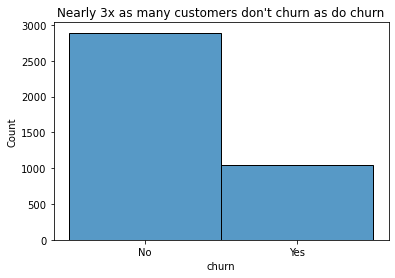

In [4]:
# Let's first see how our target variable is distributed

sns.histplot(train.churn)
plt.title('Nearly 3x as many customers don\'t churn as do churn');

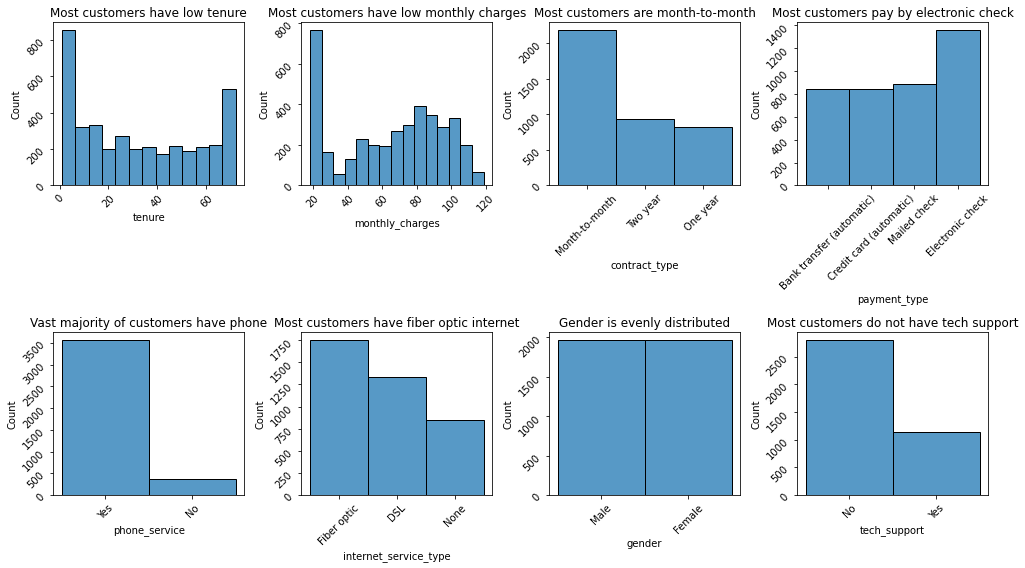

In [5]:
# Let's see how each of our chosen features is distributed

columns = [
    'tenure',
    'monthly_charges',
    'contract_type',
    'payment_type',
    'phone_service',
    'internet_service_type',
    'gender',
    'tech_support'
    
]

titles = [
    'Most customers have low tenure',
    'Most customers have low monthly charges',
    'Most customers are month-to-month',
    'Most customers pay by electronic check',
    'Vast majority of customers have phone',
    'Most customers have fiber optic internet',
    'Gender is evenly distributed',
    'Most customers do not have tech support',
    '',
    ''
]

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (14, 8))

for index, column in enumerate(columns):
    sns.histplot(
        data = train[column],
        ax = ax[index // 4][index % 4]
    )
    ax[index // 4][index % 4].tick_params(labelrotation = 45)
    ax[index // 4][index % 4].set_title(titles[index])
    
fig.tight_layout();

We see a lot of groups here that represent large proportions of the general population. One or more of these groups could be the source of the majority of our churning customers.

In particular low tenure, low monthly charges, month-to-month contract, electronic check payment, has phone service, has fiber optic internet, and not a senior citizen all represent large proportions of the whole population.

---

## Bivariate Analysis

Now we will compare our chosen features by separating customers that churned versus customers that didn't churn.

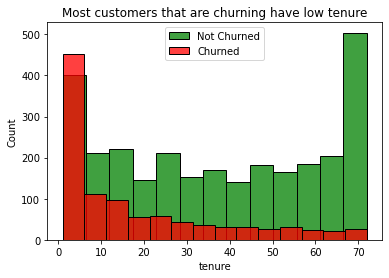

In [6]:
churned = train[train.churn == 'Yes']
not_churned = train[train.churn == 'No']

sns.histplot(data = not_churned.tenure, label = 'Not Churned', color = 'green')
sns.histplot(data = churned.tenure, label = 'Churned', color = 'red')
plt.title('Most customers that are churning have low tenure')
plt.legend();

# Additionally the rate of customers churning reduces as tenure increases

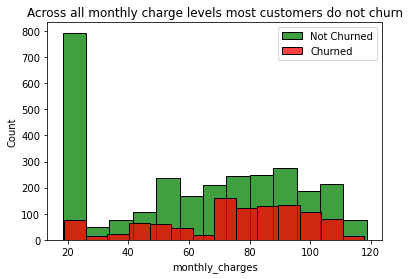

In [7]:
sns.histplot(data = not_churned.monthly_charges, label = 'Not Churned', color = 'green')
sns.histplot(data = churned.monthly_charges, label = 'Churned', color = 'red')
plt.title('Across all monthly charge levels most customers do not churn')
plt.legend();

# Additionally churn increases as monthly charges increase

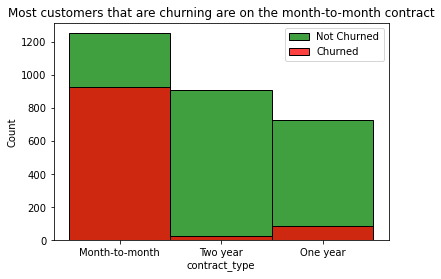

In [8]:
sns.histplot(data = not_churned.contract_type, label = 'Not Churned', color = 'green')
sns.histplot(data = churned.contract_type, label = 'Churned', color = 'red')
plt.title('Most customers that are churning are on the month-to-month contract')
plt.legend();

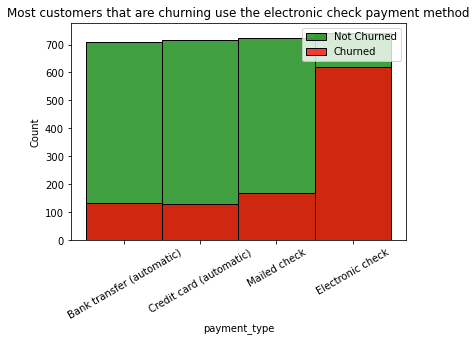

In [9]:
sns.histplot(data = not_churned.payment_type, label = 'Not Churned', color = 'green')
sns.histplot(data = churned.payment_type, label = 'Churned', color = 'red')
plt.title('Most customers that are churning use the electronic check payment method')
plt.xticks(rotation = 30)
plt.legend();

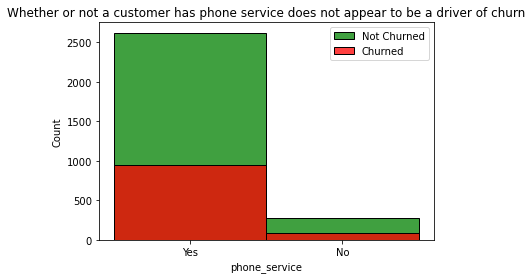

In [10]:
sns.histplot(data = not_churned.phone_service, label = 'Not Churned', color = 'green')
sns.histplot(data = churned.phone_service, label = 'Churned', color = 'red')
plt.title('Whether or not a customer has phone service does not appear to be a driver of churn')
plt.legend();

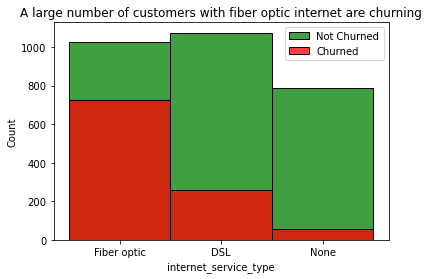

In [11]:
sns.histplot(data = not_churned.internet_service_type, label = 'Not Churned', color = 'green')
sns.histplot(data = churned.internet_service_type, label = 'Churned', color = 'red')
plt.title('A large number of customers with fiber optic internet are churning')
plt.legend();

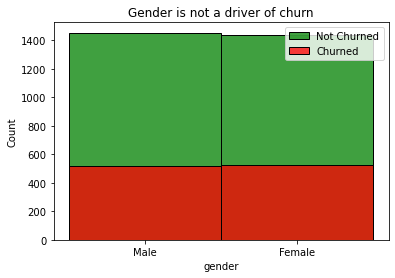

In [12]:
sns.histplot(data = not_churned.gender, label = 'Not Churned', color = 'green')
sns.histplot(data = churned.gender, label = 'Churned', color = 'red')
plt.title('Gender is not a driver of churn')
plt.legend();

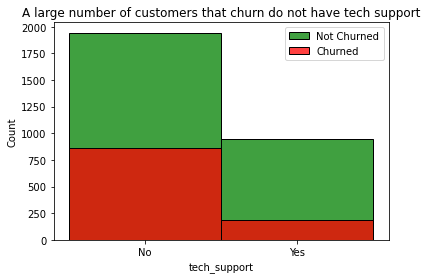

In [13]:
sns.histplot(data = not_churned.tech_support, label = 'Not Churned', color = 'green')
sns.histplot(data = churned.tech_support, label = 'Churned', color = 'red')
plt.title('A large number of customers that churn do not have tech support')
plt.legend();

From the charts above we can deduce that the most likely drivers of churn are low monthly tenure, month-to-month contract, high monthly charges, no tech support, and the electronic check payment method.

---

## Multivariate Analysis

Now let's see how our features interact with each other. Let's answer the following questions:

What's the relationship between tenure and contract_type?

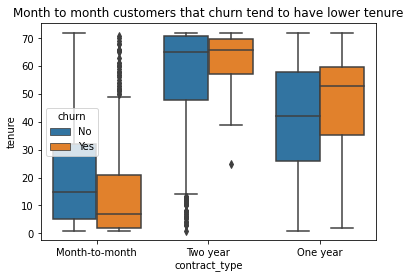

In [14]:
sns.boxplot(data = train, x = 'contract_type', y = 'tenure', hue = 'churn')
plt.title('Month to month customers that churn tend to have lower tenure');

What's the relationship between tenure and internet service type?

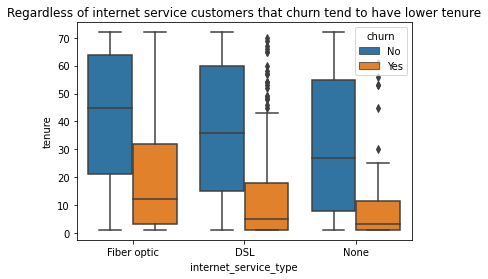

In [15]:
sns.boxplot(data = train, x = 'internet_service_type', y = 'tenure', hue = 'churn')
plt.title('Regardless of internet service customers that churn tend to have lower tenure');

What's the relationship between tenure and payment method?

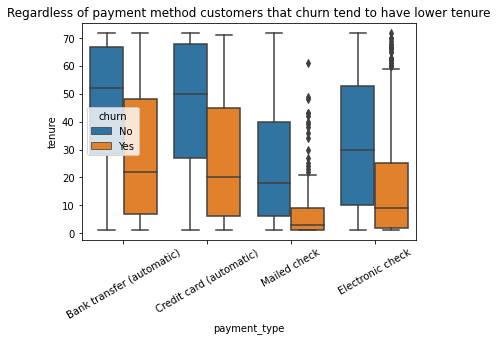

In [16]:
sns.boxplot(data = train, x = 'payment_type', y = 'tenure', hue = 'churn')
plt.xticks(rotation = 30)
plt.title('Regardless of payment method customers that churn tend to have lower tenure');

Let's see how tenure and monthly charges relate?

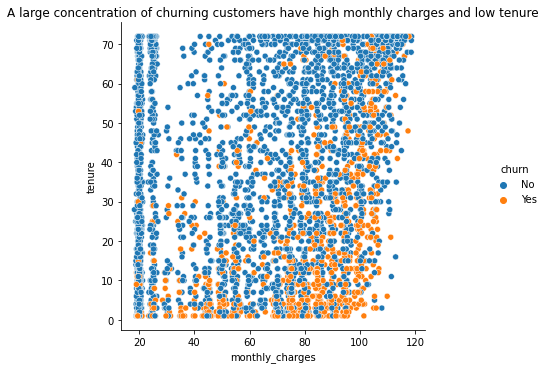

In [17]:
sns.relplot(data = train, x = 'monthly_charges', y = 'tenure', hue = 'churn')
plt.title('A large concentration of churning customers have high monthly charges and low tenure');

How do internet service and monthly charges relate?

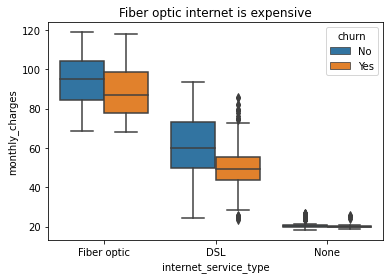

In [18]:
sns.boxplot(data = train, x = 'internet_service_type', y = 'monthly_charges', hue = 'churn')
plt.title('Fiber optic internet is expensive');

How do contract type and monthly charges relate?

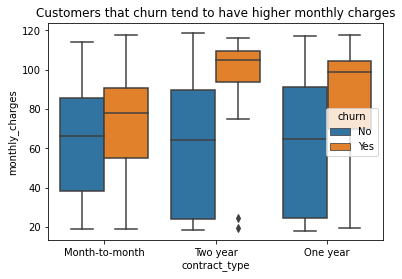

In [19]:
sns.boxplot(data = train, x = 'contract_type', y = 'monthly_charges', hue = 'churn')
plt.title('Customers that churn tend to have higher monthly charges');

What's the relationship between payment type and monthly charges?

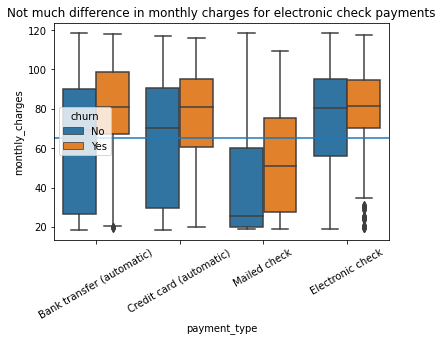

In [20]:
sns.boxplot(data = train, x = 'payment_type', y = 'monthly_charges', hue = 'churn')
plt.xticks(rotation = 30)

mean_monthly_charges = train.monthly_charges.mean()
plt.axhline(mean_monthly_charges)

plt.title('Not much difference in monthly charges for electronic check payments');

How does tech support and monthly charges relate?

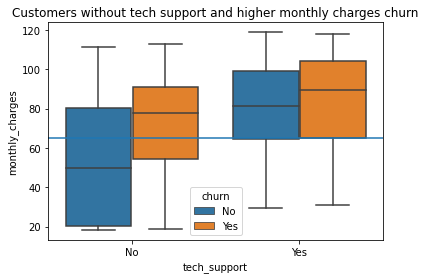

In [21]:
sns.boxplot(data = train, x = 'tech_support', y = 'monthly_charges', hue = 'churn')

mean_monthly_charges = train.monthly_charges.mean()
plt.axhline(mean_monthly_charges)

plt.title('Customers without tech support and higher monthly charges churn');

---

## Key Takeaways

From the analysis above we can deduce that the most likely drivers of churn are tenure, monthly charges, contract type, and possibly tech support.

---

## Statistical Tests

Let's now perform some statistical tests to verify if our conclusions are valid.

The stats_util module that we have in the repository can help us with conducting these statistical tests.

In [22]:
from stats_util import *

$H_0$: The mean monthly charges of customers that churn is less than or equal to the mean monthly charges of customers that do not churn.
<br>
$H_a$: The mean monthly charges of customers that churn is greater than the mean monthly charges of customers that do not churn.

In [23]:
churn_customers = train[train.churn == 'Yes']
not_churn_customers = train[train.churn == 'No']

two_sample_ttest(churn_customers.monthly_charges, not_churn_customers.monthly_charges, alternative = 'greater')

Samples contain more than 30 observations: True
Samples have equal variances: False
Using parametric test...

Reject H0


We reject the null hypothesis that customers who have churned have lower monthly charges than those who haven't.

$H_0$: Customers that churn do not have less tenure on average than customers that don't churn.
<br>
$H_a$: Customers that churn have less tenure on average than customers that don't churn.

In [24]:
two_sample_ttest(churn_customers.tenure, not_churn_customers.tenure, alternative = 'less')

Samples contain more than 30 observations: True
Samples have equal variances: False
Using parametric test...

Reject H0


We reject the null hypothesis that customers that churn do not have less tenure on average than those who don't.

$H_0$: There is no association between churn and contract type.
<br>
$H_a$: There is an association between churn and contract type.

In [25]:
chi2_test(train.churn, train.contract_type)

Observed

[[1253  730  908]
 [ 930   90   26]]
---
Expected

[[1603.   602.1  685.9]
 [ 580.   217.9  248.1]]
---

chi^2 = 660.6671
p     = 0.0000

Reject H0


We reject the null hypothesis that there is no association between churn and contract type.

$H_0$: There is no association between churn and whether or not a customer has tech support.
<br>
$H_a$: There is an association between churn and whether or not a customer has tech support.

In [26]:
chi2_test(train.churn, train.tech_support)

Observed

[[1944  947]
 [ 862  184]]
---
Expected

[[2060.5  830.5]
 [ 745.5  300.5]]
---

chi^2 = 85.5463
p     = 0.0000

Reject H0


We reject the null hypothesis that there is no association between churn and tech support.

---

## Key Takeaways

The statistical tests verify that our identification of monthly charges, tenure, contract type, and tech support as being likely drivers of churn is valid.

---

## Conclusion

With our analysis complete we can begin creating some machine learning models utilizing the features we identifying as being the most likely drivers of churn. Additionally we can abstract some of the code providing our key insights into an explore.py file for use in the final report notebook.